<a href="https://colab.research.google.com/github/sara-alnahhas/task/blob/master/Diamonds_Project_Group6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing Libraries for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRFRegressor

print('Setting up the Libraries...')
print('Setup complete!')

Setting up the Libraries...
Setup complete!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
#Importing the dataset
diamonds_data = pd.read_csv('diamonds.csv', index_col=0)

diamonds_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
diamonds_data.shape


(53940, 10)

In [5]:
diamonds_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [6]:
diamonds_data['price'] = diamonds_data['price'].astype(float)

In [7]:
categorical_cols = [cname for cname in diamonds_data.columns if diamonds_data[cname].dtype == "object"]
for cat in categorical_cols:
  print(cat)
  print(diamonds_data[cat].value_counts())
  print('---------------------------------')

cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64
---------------------------------
color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64
---------------------------------
clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64
---------------------------------


In [8]:
diamonds_data[(diamonds_data['x'] == 0)|(diamonds_data['y'] == 0)|(diamonds_data['z'] == 0)].count()

carat      20
cut        20
color      20
clarity    20
depth      20
table      20
price      20
x          20
y          20
z          20
dtype: int64

In [9]:
diamond_copy = diamonds_data.copy()
diamond_copy.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334.0,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75


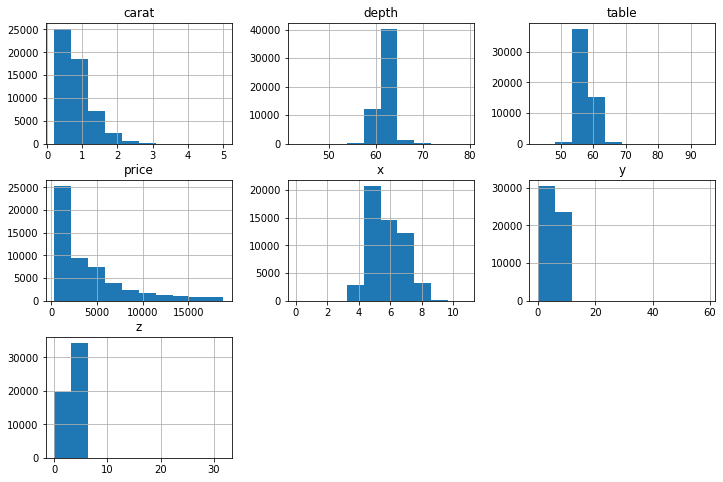

In [10]:
diamond_copy.hist(figsize=(12,8))
plt.show()

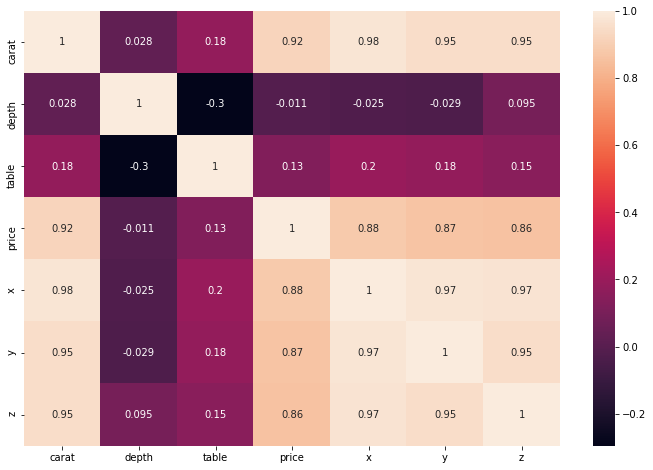

In [11]:
corr_matrix = diamond_copy.corr()
# print(corr_matrix)
plt.subplots(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

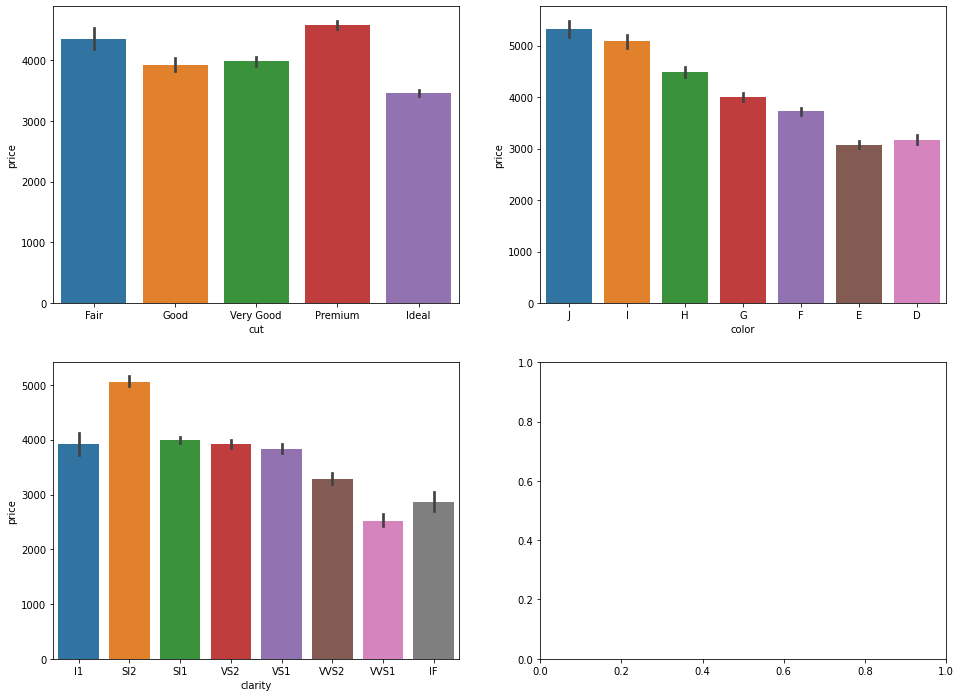

In [12]:
fig, saxis = plt.subplots(2, 2,figsize=(16,12))
sns.barplot(x = 'cut', y = 'price', order=['Fair','Good','Very Good','Premium','Ideal'], data=diamond_copy, ax = saxis[0,0])
sns.barplot(x = 'color', y = 'price', order=['J','I','H','G','F','E','D'], data=diamond_copy, ax = saxis[0,1])
sns.barplot(x = 'clarity', y = 'price', order=['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF'], data=diamond_copy, ax = saxis[1,0])

In [13]:
diamond_copy = diamond_copy[(diamond_copy[['x', 'y', 'z']] != 0).all(axis=1)]
print(diamond_copy.shape)
# diamond_copy[(diamond_copy['x'] == 0)|(diamond_copy['y'] == 0)|(diamond_copy['z'] == 0)]

(53920, 10)


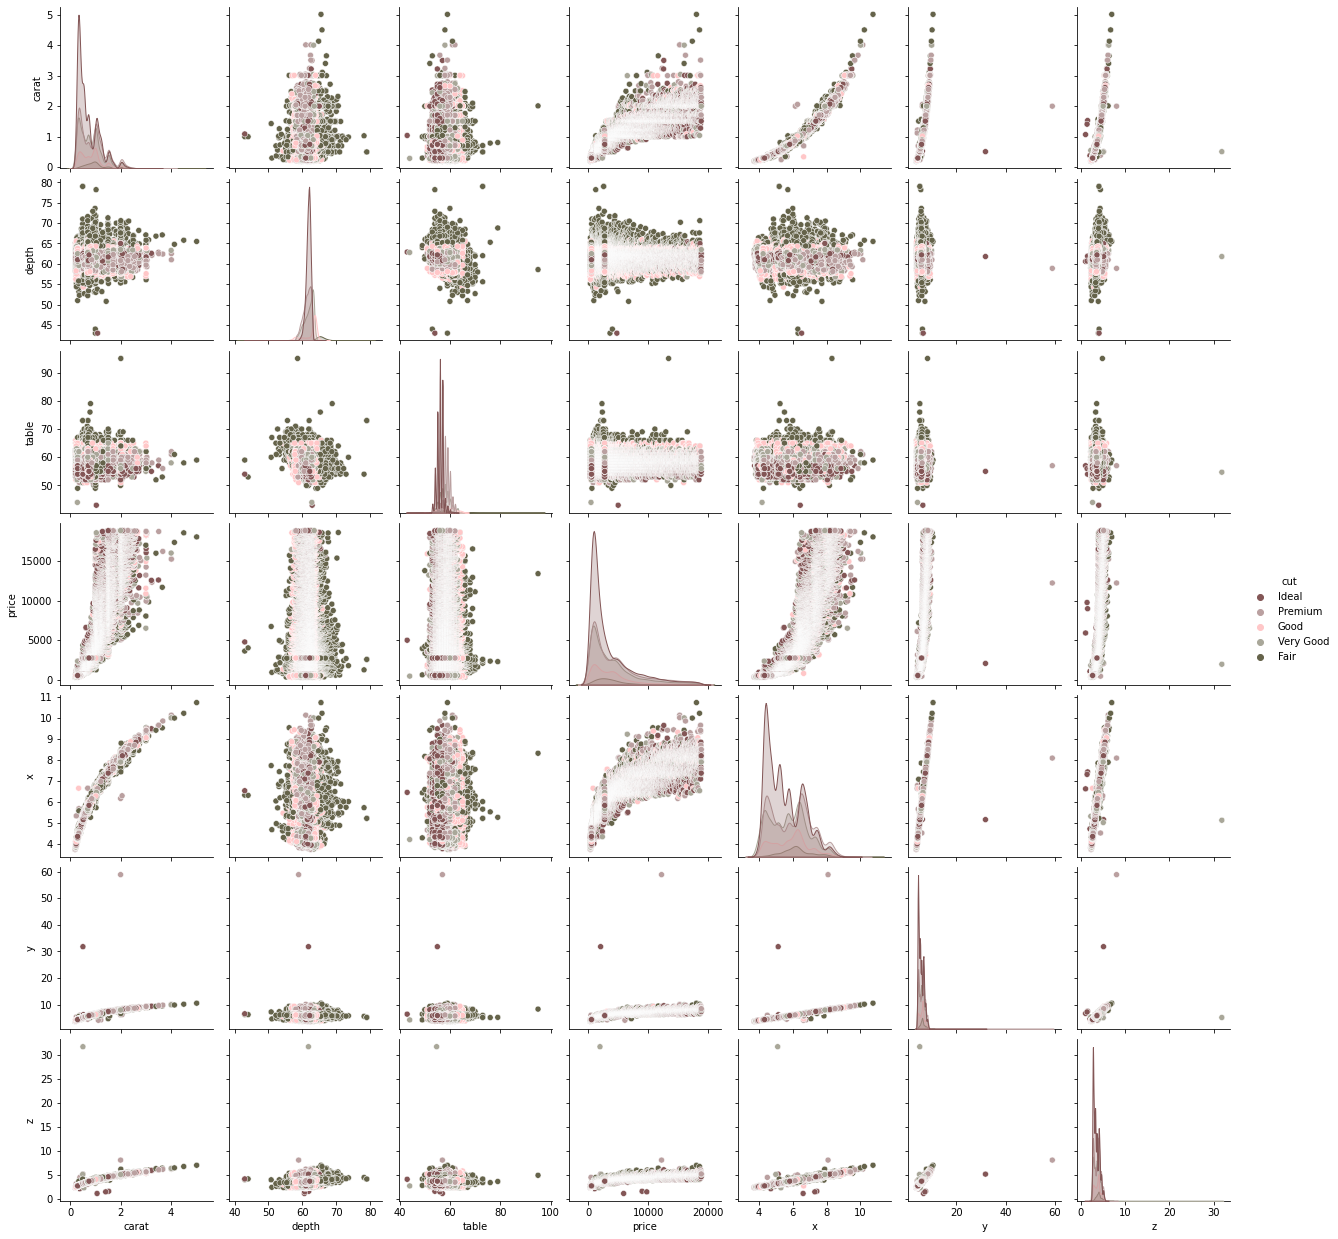

In [14]:
shade = ["#835656", "#baa0a0", "#ffc7c8", 
         "#a9a799", "#65634a"]#shades for hue         
ax = sns.pairplot(diamond_copy, 
                  hue= "cut",palette=shade)

In [15]:
Q1 = diamond_copy.quantile(0.25)
Q3 = diamond_copy.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

carat       0.64
depth       1.50
table       3.00
price    4374.25
x           1.83
y           1.82
z           1.13
dtype: float64


In [16]:
diamond_copy_out = diamond_copy[~((diamond_copy < (Q1 - 1.5 * IQR)) |(diamond_copy > (Q3 + 1.5 * IQR))).any(axis=1)]
diamond_copy_out.shape

(47524, 10)

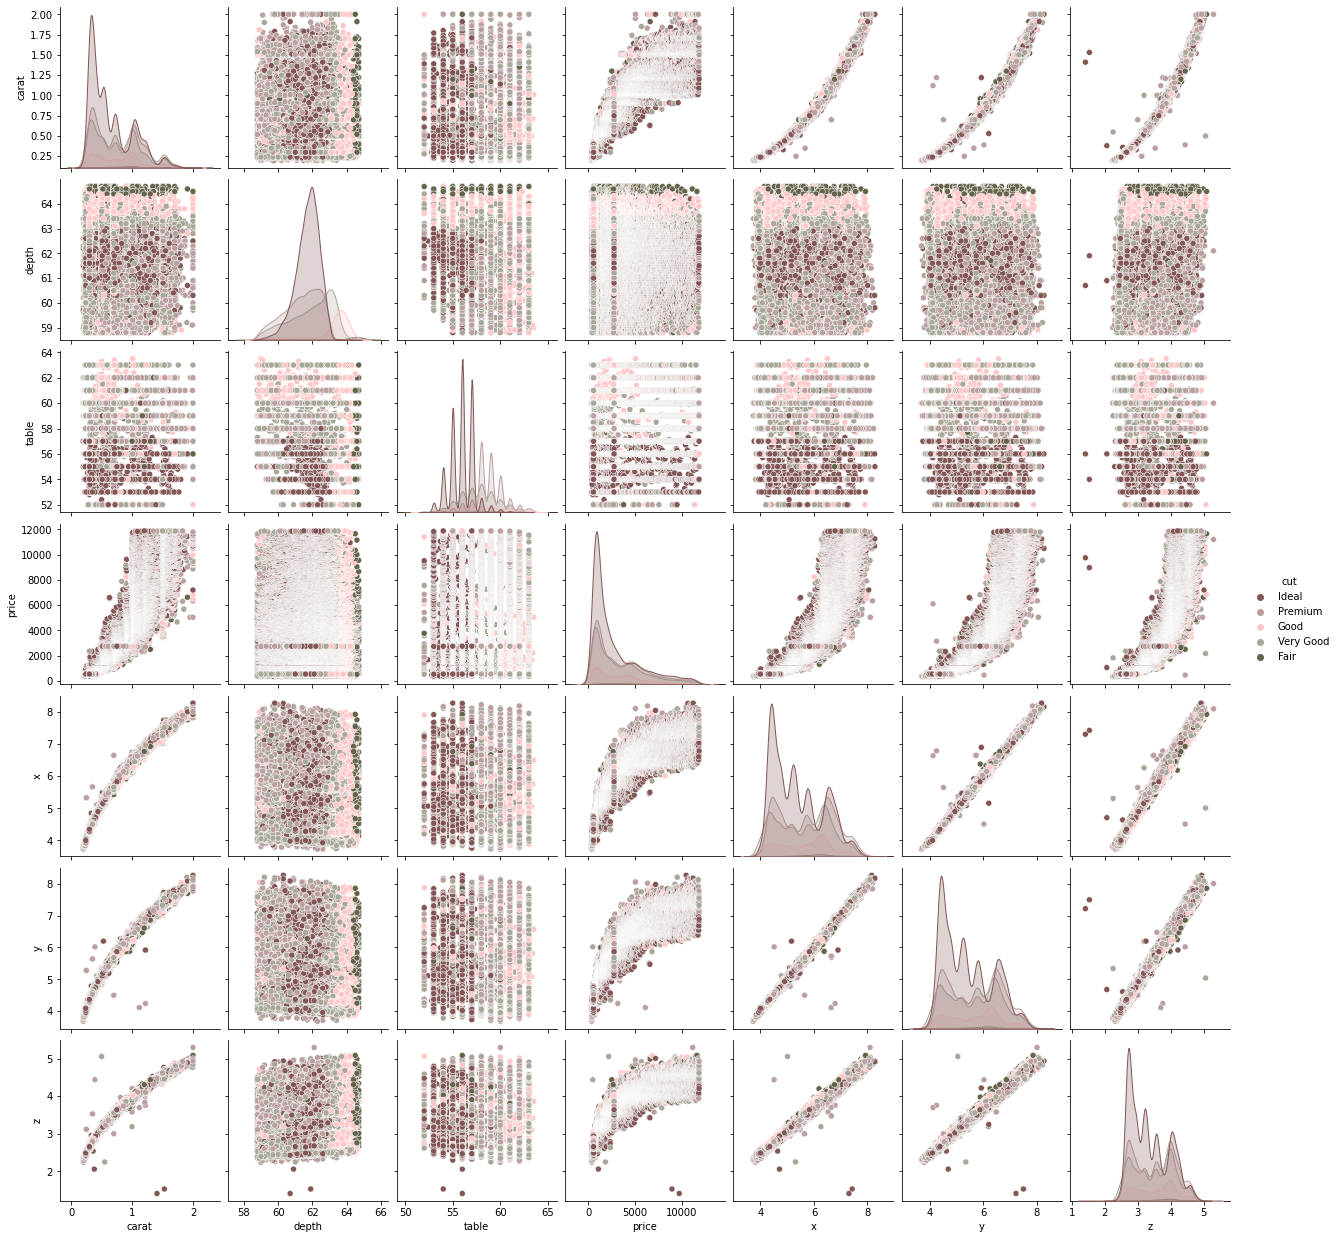

In [17]:
ax = sns.pairplot(diamond_copy_out, 
                  hue= "cut",palette=shade)

In [18]:
s = (diamond_copy_out.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['cut', 'color', 'clarity']


In [19]:
diamond_labels = diamond_copy_out.copy()


ordinal_encoder = OrdinalEncoder(categories = [['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], 
                                               ['J', 'I', 'H', 'G', 'F', 'E', 'D'],
                                              ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']])
diamond_labels[object_cols] = ordinal_encoder.fit_transform(diamond_labels[object_cols])

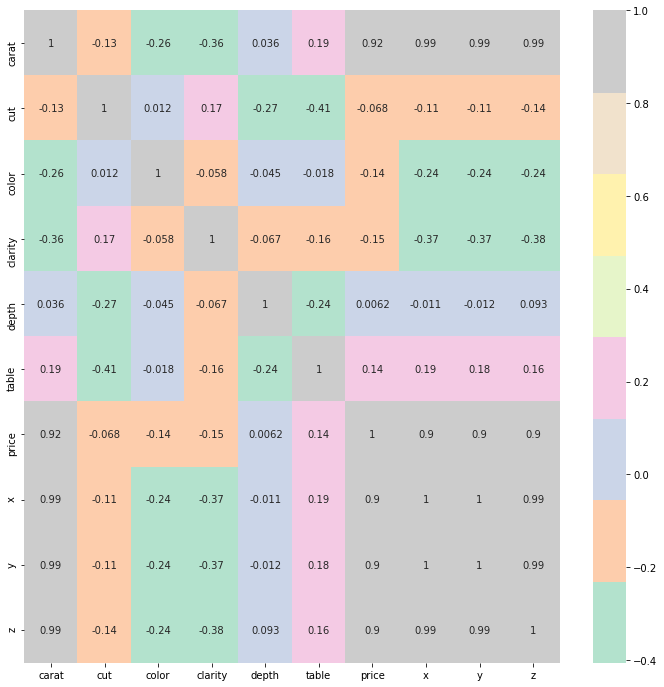

In [20]:
corrmat= diamond_labels.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap="Pastel2",annot=True)

In [21]:
X= diamond_labels.drop(["price"],axis =1)
y= diamond_labels["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=7)


In [22]:
def score_dataset(X_train, X_valid, y_train, y_valid, model):
    model = model
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)
    return 'mse: {}, rsme: {}'.format(mae, np.sqrt(mean_squared_error(y_valid, preds)))

In [23]:
print('LinearRegression: ', score_dataset(X_train, X_test, y_train, y_test, LinearRegression()))

LinearRegression:  mse: 564.4745638762246, rsme: 817.9844925422283


In [24]:
print('RandomForest: ', score_dataset(X_train, X_test, y_train, y_test, RandomForestRegressor()))

RandomForest:  mse: 199.4458448423052, rsme: 365.40767099194454


In [25]:
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor())
                             ])
# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print("cross_val_scores mean:{}".format(scores.mean()))

MAE scores:
 [ 569.29381543 1124.85101747  689.77249815  204.01218921  380.75593287]
cross_val_scores mean:593.7370906250749


In [26]:
print('XGBRFRegressor: ', score_dataset(X_train, X_test, y_train, y_test, XGBRFRegressor()))

[12:14:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRFRegressor:  mse: 565.8062989647747, rsme: 917.4652500599486


In [27]:
print('XGBRFRegressor with hyperparameters change: ' ,score_dataset(X_train, X_test, y_train, y_test, XGBRFRegressor(n_estimators=1000, learning_rate=0.05)))

[12:15:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRFRegressor with hyperparameters change:  mse: 2994.345619170195, rsme: 4006.8588467302275


In [28]:
my_model = RandomForestRegressor()
my_model.fit(X_train, y_train)
pred = my_model.predict(X_test)
print(mean_absolute_error(y_test, pred))
print(np.sqrt(mean_squared_error(y_test, pred)))

199.4307617594719
364.9119164037703


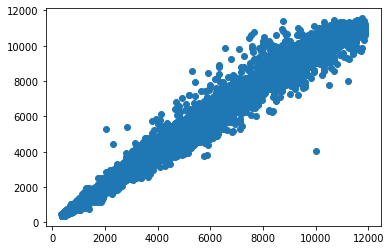

In [29]:
plt.scatter(y_test, pred)

In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = [
 {'n_estimators': [100, 150, 200], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
 scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [31]:
grid_search.best_params_


{'max_features': 6, 'n_estimators': 200}

In [32]:
grid_search.best_estimator_


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [35]:
my_model2 = RandomForestRegressor(n_estimators=200,random_state= None)
my_model2.fit(X_train, y_train)
pred = my_model2.predict(X_test)
print(mean_absolute_error(y_test, pred))
print(np.sqrt(mean_squared_error(y_test, pred)))

199.16607062747246
364.5495368088037
